In [1]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    # Місце для вашого коду
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    # Другий шар, який складається з 256 нейронів
    # Місце для вашого коду
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    # Вихідний шар
    # Місце для вашого коду
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    # Місце для вашого коду
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)

    return self.out_layer(x, activation=1) # Місце для вашого коду

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    # ...
    # Отримуємо індекс класу з найвищою ймовірністю
    predicted_class = tf.argmax(y_pred, axis=1)

    # Порівнюємо передбачені класи з правильними класами
    correct_prediction = tf.equal(predicted_class, tf.cast(y_true, tf.int64))

    # Обчислюємо точність
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Місце для вашого коду
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    # Місце для вашого коду
    gradients = g.gradient(loss, trainable_variables)
    # Модифікуємо параметри
    # Місце для вашого коду
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [9]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss.numpy())
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc.numpy())

        print(f"Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

Step 100, Loss: 310.7133483886719, Accuracy: 0.5546875
Step 200, Loss: 279.0570068359375, Accuracy: 0.56640625
Step 300, Loss: 257.961181640625, Accuracy: 0.6015625
Step 400, Loss: 272.2945556640625, Accuracy: 0.55859375
Step 500, Loss: 248.04139709472656, Accuracy: 0.56640625
Step 600, Loss: 267.11248779296875, Accuracy: 0.54296875
Step 700, Loss: 233.224609375, Accuracy: 0.578125
Step 800, Loss: 259.17999267578125, Accuracy: 0.52734375
Step 900, Loss: 261.65948486328125, Accuracy: 0.55859375
Step 1000, Loss: 269.739501953125, Accuracy: 0.57421875
Step 1100, Loss: 249.25816345214844, Accuracy: 0.60546875
Step 1200, Loss: 286.1812744140625, Accuracy: 0.5625
Step 1300, Loss: 277.71942138671875, Accuracy: 0.5859375
Step 1400, Loss: 247.00738525390625, Accuracy: 0.52734375
Step 1500, Loss: 279.90728759765625, Accuracy: 0.5234375
Step 1600, Loss: 225.8424530029297, Accuracy: 0.6015625
Step 1700, Loss: 254.0255126953125, Accuracy: 0.59375
Step 1800, Loss: 244.49742126464844, Accuracy: 0.593

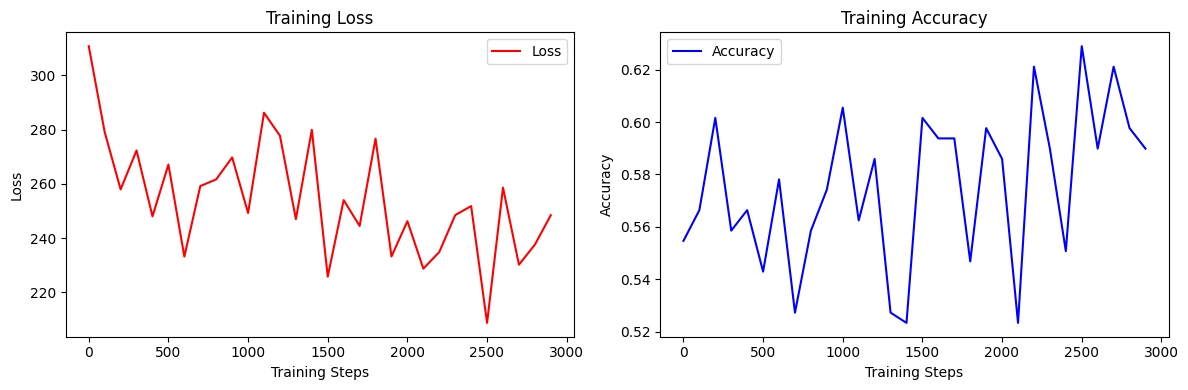

In [10]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# Місце для вашого коду
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps+1, display_step), loss_history, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
# Виведіть графік точності
# Місце для вашого коду
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps+1, display_step), accuracy_history, label='Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
# Тестування моделі на тестових даних
# Місце для вашого коду
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size)

test_accuracy = tf.keras.metrics.Accuracy()

for test_x, test_y in test_data:
    test_pred = neural_net(test_x)
    test_accuracy.update_state(tf.argmax(test_pred, axis=1), test_y)

print(f"Test Accuracy: {test_accuracy.result().numpy() * 100:.2f}%")

Test Accuracy: 58.12%


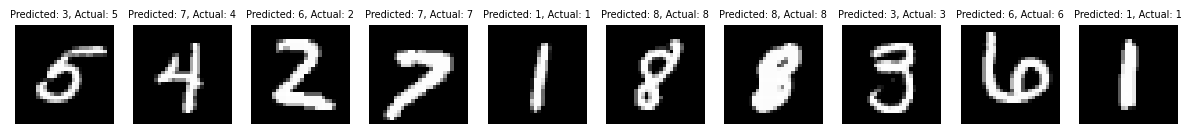

In [18]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
# Протестуйте навчену нейромережу на 10 зображеннях
num_test_images = 10

# Виберіть випадкові зображення з тестової вибірки
random_test_indices = random.sample(range(len(x_test)), num_test_images)
test_images = x_test[random_test_indices]
test_labels = y_test[random_test_indices]

# Передайте зображення у нейронну мережу та отримайте передбачення
predictions = neural_net(test_images)

# Виведіть зображення та випишіть відповіді нейромережі
plt.figure(figsize=(15, 5))
for i in range(num_test_images):
    plt.subplot(1, num_test_images, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
    plt.title(f"Predicted: {tf.argmax(predictions[i])}, Actual: {test_labels[i]}", fontsize=7)
    plt.axis('off')
plt.show()